In [1000]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection, tree
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [77]:
df = pd.read_csv('CandidateSummaryAction.csv')

In [78]:
df.columns

Index(['can_id', 'can_nam', 'can_off', 'can_off_sta', 'can_off_dis',
       'can_par_aff', 'can_inc_cha_ope_sea', 'can_str1', 'can_str2', 'can_cit',
       'can_sta', 'can_zip', 'ind_ite_con', 'ind_uni_con', 'ind_con',
       'par_com_con', 'oth_com_con', 'can_con', 'tot_con',
       'tra_fro_oth_aut_com', 'can_loa', 'oth_loa', 'tot_loa',
       'off_to_ope_exp', 'off_to_fun', 'off_to_leg_acc', 'oth_rec', 'tot_rec',
       'ope_exp', 'exe_leg_acc_dis', 'fun_dis', 'tra_to_oth_aut_com',
       'can_loa_rep', 'oth_loa_rep', 'tot_loa_rep', 'ind_ref', 'par_com_ref',
       'oth_com_ref', 'tot_con_ref', 'oth_dis', 'tot_dis',
       'cas_on_han_beg_of_per', 'cas_on_han_clo_of_per', 'net_con',
       'net_ope_exp', 'deb_owe_by_com', 'deb_owe_to_com', 'cov_sta_dat',
       'cov_end_dat', 'winner', 'votes'],
      dtype='object')

In [79]:
df['winner'].fillna('N', inplace = True)

In [80]:
df.columns = ['ID', 'Name', 'Office', 'State Race', 'District', 'Party', 'Seat', 'Address', 'Address 2', 'City', 'State', 'Zip','Ind Item Con', 'Ind Unitem Con', 'Total Ind Con',
       'Party Con', 'Other Cmte Con', 'Can Con', 'Total Con',
       'Xfer From Other Cmte', 'Can Loan', 'Other Loan', 'Total Loan',
       'Ops Offset', 'FundR Offset', 'Legal Offset', 'Other Receipts', 'Total Receipts',
       'Ops Expense', 'Legal Expense', 'Fund Distro', 'Xfer To Other Cmte',
       'Can Loan Repay', 'Other Loan Repay', 'Total Loan Repay', 'Indi Refund', 'Party Refund',
       'Other Cmte Refund', 'Total Refund', 'Other Distro', 'Total Distro',
       'Starting Amount', 'Ending Amount', 'Net Con',
       'Net Ops Expense', 'Debt Owed by Cmte', 'Debt Owed to Cmte', 'Coverage Start',
       'Coverage End', 'Winner', 'Total Votes']

# Lots of votes missing, any predictions would be classifications

In [81]:
df[df['Total Votes'].isnull()==True].shape

(1435, 51)

# Dropping all columns that breakdown totals and expenses I am only interested in the end result and there are a ton of null values in many of the columns being dropped

In [82]:
df = df.drop(columns=['Address', 'Address 2', 'City', 'State', 'Zip','Ind Item Con', 'Ind Unitem Con','Total Ind Con','Party Con', 'Other Cmte Con', 'Can Con',
                'Xfer From Other Cmte', 'Can Loan', 'Other Loan','Total Loan',
       'Ops Offset', 'FundR Offset', 'Legal Offset', 'Other Receipts', 'Total Receipts',
       'Ops Expense', 'Legal Expense', 'Fund Distro', 'Xfer To Other Cmte',
       'Can Loan Repay', 'Other Loan Repay', 'Total Loan Repay', 'Indi Refund', 'Party Refund',
       'Other Cmte Refund', 'Total Refund', 'Other Distro', 'Total Distro',
       'Starting Amount', 'Ending Amount', 'Debt Owed by Cmte', 'Debt Owed to Cmte','Total Votes'])

In [83]:
df.isna().sum()

ID                   0
Name                 0
Office               0
State Race           0
District             2
Party                1
Seat                 2
Total Con          119
Net Con            171
Net Ops Expense    149
Coverage Start       0
Coverage End         0
Winner               0
dtype: int64

# Dropping rows without money as they wouldn't help 

In [84]:
df = df.dropna(subset=['Total Con', 'Net Con', 'Net Ops Expense'])

# Adding column to see how long the campaigned for to see if it makes a difference

In [85]:
df[['Coverage Start', 'Coverage End']] = df[['Coverage Start', 'Coverage End']].apply(pd.to_datetime)

In [86]:
df['Coverage Duration'] = (df['Coverage End'] - df['Coverage Start']).dt.days

In [87]:
df['Office'].value_counts(normalize=True, sort=True) * 100

H    83.803681
S    12.515337
P     3.680982
Name: Office, dtype: float64

# cleaning up data types

In [88]:
df['Total Con']= df['Total Con'].str.replace('$', '').str.replace(',','')
df['Net Con']= df['Net Con'].str.replace('$', '').str.replace(',','')
df['Net Ops Expense']= df['Net Ops Expense'].str.replace('$', '').str.replace(',','')

<ipython-input-88-b2547b194fd8>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Total Con']= df['Total Con'].str.replace('$', '').str.replace(',','')
<ipython-input-88-b2547b194fd8>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Net Con']= df['Net Con'].str.replace('$', '').str.replace(',','')
<ipython-input-88-b2547b194fd8>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Net Ops Expense']= df['Net Ops Expense'].str.replace('$', '').str.replace(',','')


In [89]:
df['Net Con'].iloc[1123] = 933.00

C:\Users\NaniTF\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [90]:
df[['Total Con', 'Net Con', 'Net Ops Expense']] = df[['Total Con', 'Net Con', 'Net Ops Expense']].apply(pd.to_numeric)

In [ ]:
#seperating races

In [91]:
df_h = df[df['Office']=='H']
df_s = df[df['Office']=='S']
df_p = df[df['Office']=='P']

In [ ]:
#going to start looking at districts in house races and how much is spent

In [92]:
state_dtot = df_h.groupby(['State Race', 'District'])['Net Ops Expense'].sum().to_frame(name = 'Dtot Spend').reset_index()

In [93]:
state_dtot.head()

,State Race,District,Dtot Spend
0,AK,0.0,1145563.60
1,AL,1.0,941648.85
2,AL,2.0,1557982.20
3,AL,3.0,880649.80
4,AL,4.0,1319197.12


# looking at states with most spending

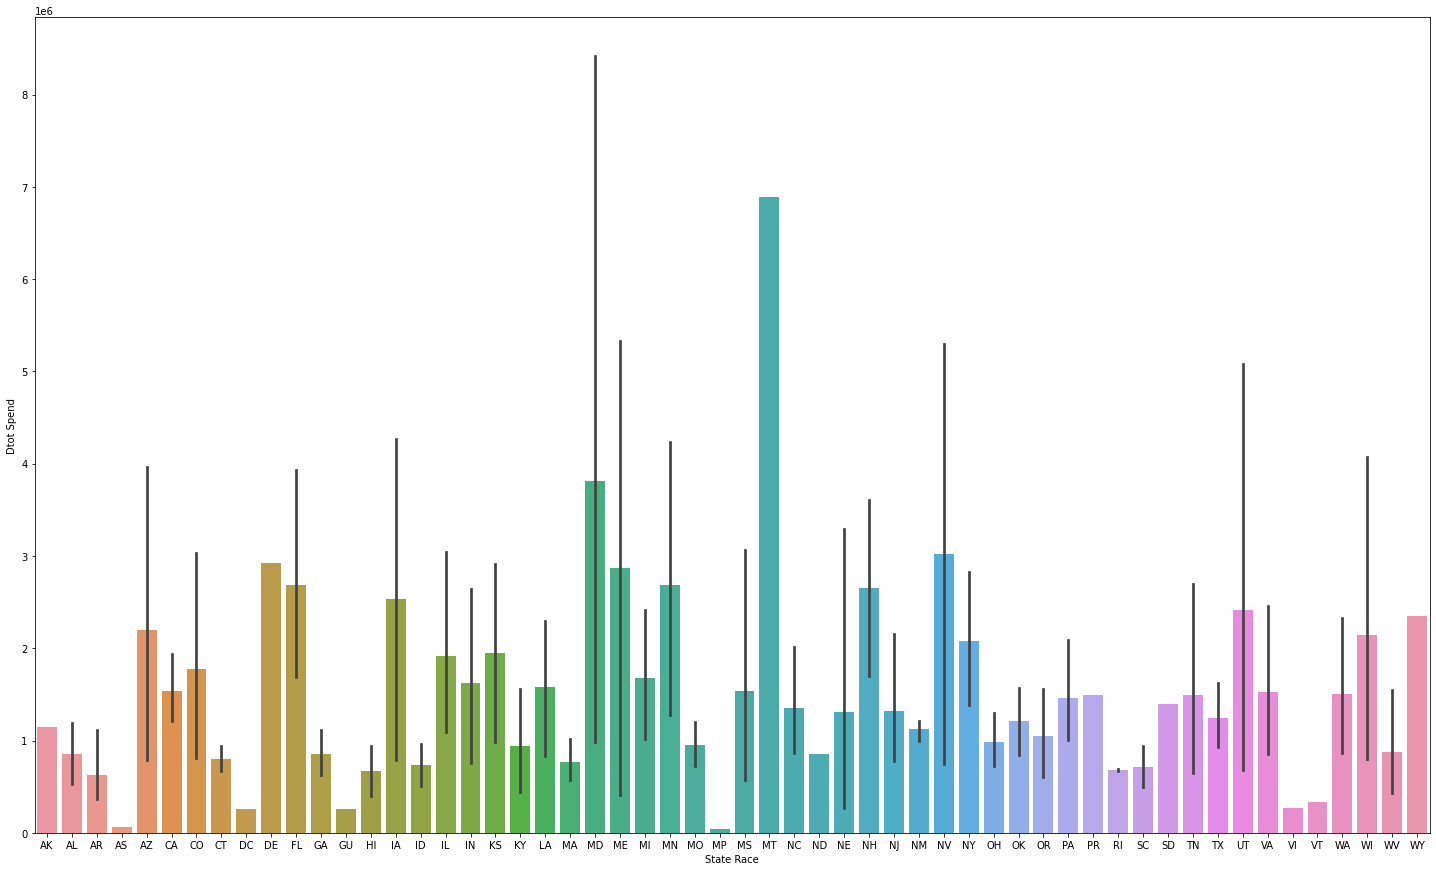

In [94]:
plt.figure(figsize=(25,15))

ax = sns.barplot(x='State Race', y='Dtot Spend', data=state_dtot)

# not sure why MT is so high but we are gonna follow the money

In [95]:
df_h[df_h['State Race'] == 'MT']

,ID,Name,Office,State Race,District,Party,Seat,Total Con,Net Con,Net Ops Expense,Coverage Start,Coverage End,Winner,Coverage Duration
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,4980915.41,4938943.74,5055942.15,2015-01-01,2016-10-19,Y,657
535,H6MT01095,"JUNEAU, DENISE",H,MT,0.0,DEM,CHALLENGER,2354440.91,2317465.07,1831515.23,2015-11-04,2016-10-19,N,350


# looking at Maryland too just to see if it holds up on money spent

In [96]:
df_h[df_h['State Race'] == 'MD']

,ID,Name,Office,State Race,District,Party,Seat,Total Con,Net Con,Net Ops Expense,Coverage Start,Coverage End,Winner,Coverage Duration
50,H8MD01094,"HARRIS, ANDREW P",H,MD,1.0,REP,INCUMBENT,1187269.96,1184269.96,500548.29,2015-01-01,2016-10-19,Y,657
58,H2MD05155,"HOYER, STENY HAMILTON",H,MD,5.0,DEM,INCUMBENT,3287891.58,3281401.58,1481833.31,2015-01-01,2016-10-19,Y,657
72,H6MD04209,"BROWN, ANTHONY GREGORY",H,MD,4.0,DEM,OPEN,1162306.44,1154476.44,1057499.39,2015-01-01,2016-10-19,Y,657
92,H6MD07160,"CUMMINGS, ELIJAH E",H,MD,7.0,DEM,INCUMBENT,1013044.15,999444.15,533008.78,2015-01-01,2016-10-19,Y,657
163,H6MD03292,"SARBANES, JOHN P. MR.",H,MD,3.0,DEM,INCUMBENT,923450.52,921950.52,533199.04,2015-01-01,2016-10-19,Y,657
182,H6MD08457,"RASKIN, JAMIE",H,MD,8.0,DEM,OPEN,2400678.42,2393184.69,2002326.81,2015-04-03,2016-10-19,Y,565
244,H2MD02160,"RUPPERSBERGER, C.A. DUTCH",H,MD,2.0,DEM,INCUMBENT,997739.19,996739.19,717385.62,2015-01-01,2016-10-19,Y,657
268,H2MD06195,"DELANEY, JOHN K",H,MD,6.0,DEM,INCUMBENT,1602913.06,1600513.06,1340009.35,2015-01-01,2016-10-19,Y,657
416,H4MD05144,"ARNESS, MARK KENNETH",H,MD,5.0,REP,CHALLENGER,22319.79,21819.79,41632.30,2015-01-01,2016-10-19,N,657
519,H6MD06212,"HOEBER, AMIE",H,MD,6.0,REP,CHALLENGER,571689.32,568839.32,945139.36,2015-07-01,2016-10-19,N,476


# so far holding true the more you spend the more likely you are to win

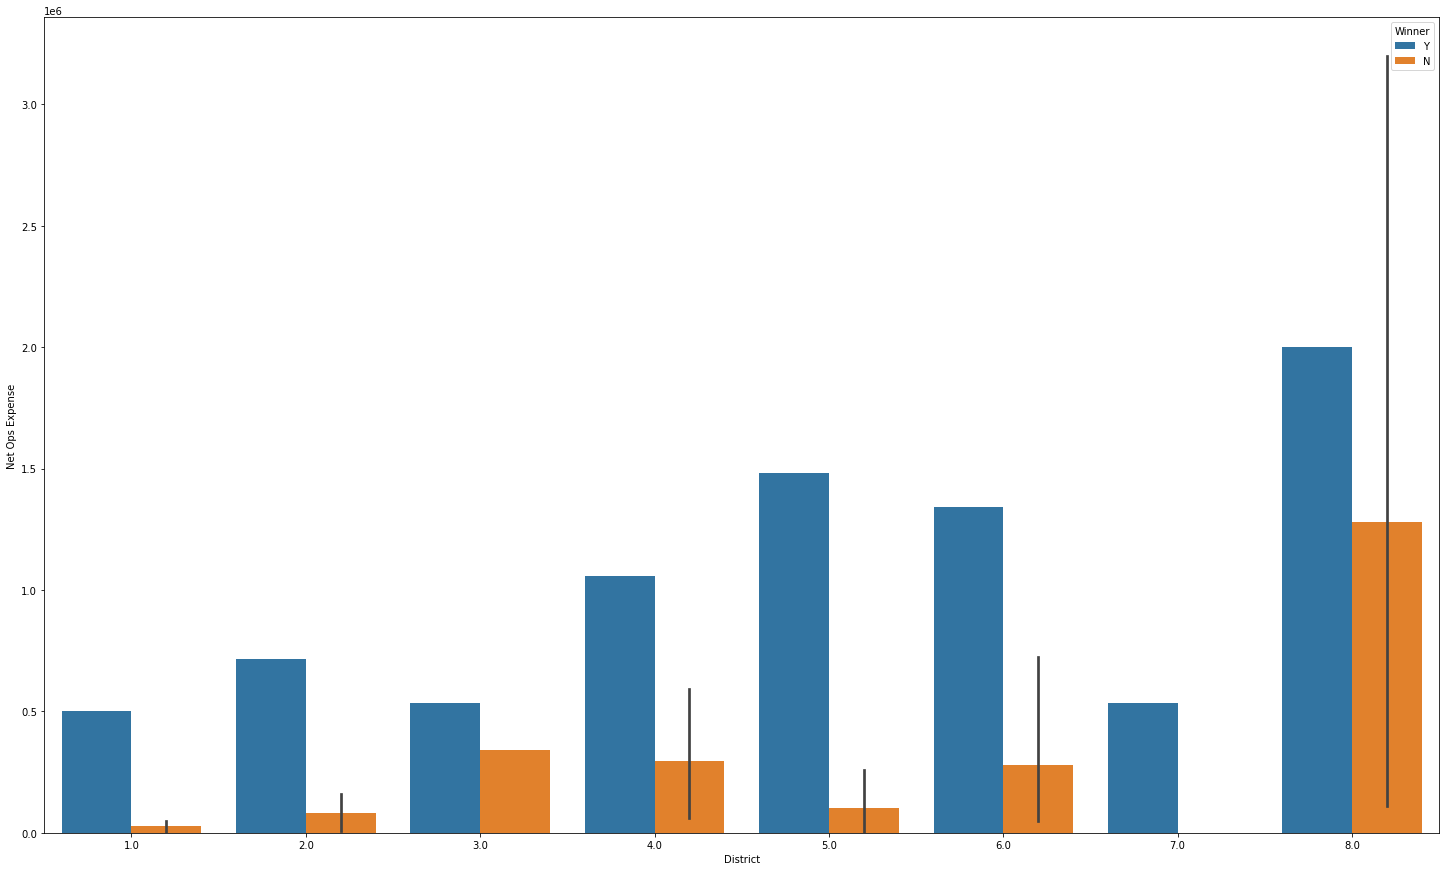

In [97]:
plt.figure(figsize=(25,15))
ax = sns.barplot(x='District', y='Net Ops Expense', hue = 'Winner',data=df_h[df_h['State Race']=='MD'])

In [98]:
#looking at senate data to see if money holds up there as well
tSen_Spend = df_s.groupby(['State Race'])['Net Ops Expense'].sum().to_frame(name = 'tSen Spend').reset_index()

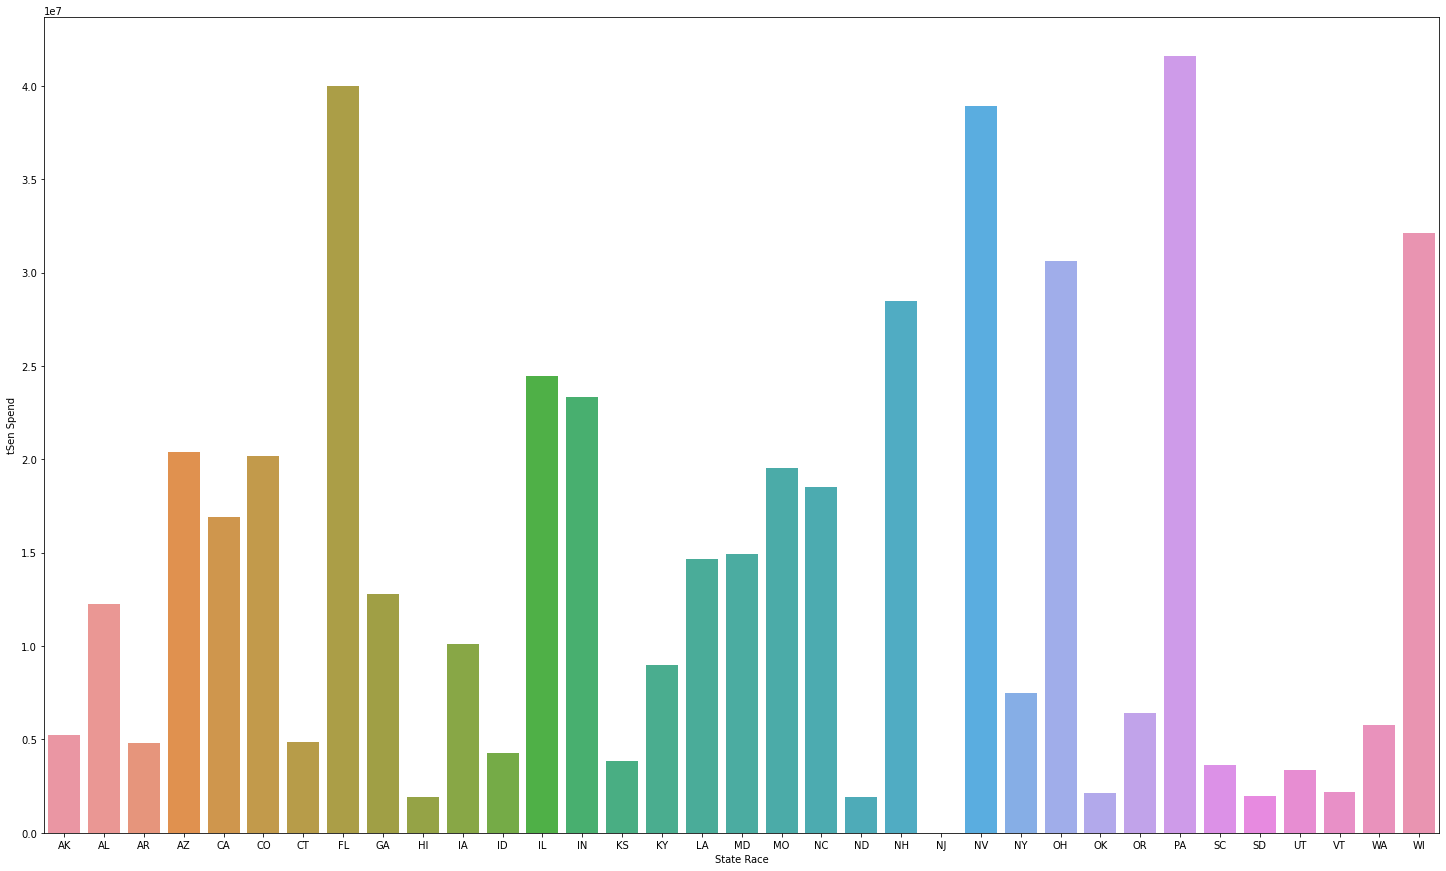

In [99]:
plt.figure(figsize=(25,15))
ax = sns.barplot(x='State Race', y='tSen Spend',data=tSen_Spend)
#PA,FL,NV are top three spenders will follow the money to see if it holds up

In [100]:
pa_race = df_s[df_s['State Race']=='PA']
fl_race = df_s[df_s['State Race']=='FL']
nv_race = df_s[df_s['State Race']=='NV']

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'MCGINTY, KATHLEEN ALANA'),
  Text(1, 0, 'FETTERMAN, JOHN KART'),
  Text(2, 0, 'PAWLOWSKI, ED'),
  Text(3, 0, 'SESTAK, JOSEPH A JR'),
  Text(4, 0, 'STERN, EVERETT ALEXANDER'),
  Text(5, 0, 'VODVARKA, JOSEPH JOHN'),
  Text(6, 0, 'HUDOCK, BRANDON GENE'),
  Text(7, 0, 'TOOMEY, PATRICK JOSEPH')])

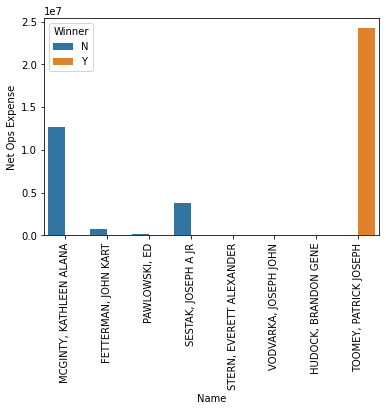

In [101]:
ax = sns.barplot(x='Name', y='Net Ops Expense', hue='Winner', data=pa_race)
plt.xticks(
rotation=90)
#money holds up here pretty heavy. Going to check other two.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'DALACK, BASIL EDWARD'),
  Text(1, 0, 'JOLLY, DAVID W'),
  Text(2, 0, 'KHOURY, ANTON'),
  Text(3, 0, 'MURPHY, PATRICK E'),
  Text(4, 0, 'NATHAN, BRUCE'),
  Text(5, 0, 'STANTON, PAUL ANTHONY'),
  Text(6, 0, 'DE LA FUENTA, ROQUE ROCKY'),
  Text(7, 0, 'GRAYSON, ALAN MARK'),
  Text(8, 0, 'GUTHRIE, SEAN PATRICK'),
  Text(9, 0, 'KEITH, PAMELA MICHELE'),
  Text(10, 0, 'LOPEZ-CANTERA, CARLOS'),
  Text(11, 0, 'LUSTER, REGINALD'),
  Text(12, 0, 'RIVERA, ERNESTO J'),
  Text(13, 0, 'YOUNG, DWIGHT MARK ANTHONY'),
  Text(14, 0, 'BERUFF, CARLOS'),
  Text(15, 0, 'INVICTUS, AUGUSTUS SOL'),
  Text(16, 0, 'RUBIO, MARCO')])

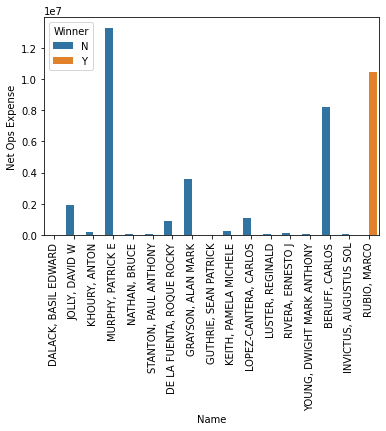

In [102]:
ax = sns.barplot(x='Name', y='Net Ops Expense', hue='Winner', data=fl_race)
plt.xticks(
rotation=90)
#our first outlier

In [103]:
fl_race

,ID,Name,Office,State Race,District,Party,Seat,Total Con,Net Con,Net Ops Expense,Coverage Start,Coverage End,Winner,Coverage Duration
470,S6FL00459,"DALACK, BASIL EDWARD",S,FL,0.0,REP,CHALLENGER,5220.00,5220.00,10.00,2016-04-13,2016-10-19,N,189
532,S6FL00350,"JOLLY, DAVID W",S,FL,0.0,REP,CHALLENGER,1851509.95,1826909.95,1915655.96,2015-01-01,2016-10-19,N,657
542,S6FL00434,"KHOURY, ANTON",S,FL,0.0,OTH,CHALLENGER,73821.00,73821.00,171719.00,2016-01-01,2016-10-19,N,292
597,S6FL00319,"MURPHY, PATRICK E",S,FL,0.0,DEM,CHALLENGER,13722407.00,13682705.00,13324181.00,2015-01-01,2016-10-19,N,657
599,S6FL00327,"NATHAN, BRUCE",S,FL,0.0,IND,CHALLENGER,3116.00,3116.00,17150.00,2015-06-20,2016-10-19,N,487
665,S6FL00467,"STANTON, PAUL ANTHONY",S,FL,0.0,LIB,CHALLENGER,19730.00,18730.00,18893.00,2016-04-01,2016-10-19,N,201
733,S6FL00509,"DE LA FUENTA, ROQUE ROCKY",S,FL,0.0,DEM,CHALLENGER,140.00,140.00,874534.00,2016-04-01,2016-10-11,N,193
826,S6FL00376,"GRAYSON, ALAN MARK",S,FL,0.0,DEM,CHALLENGER,4145499.94,4139832.78,3585661.00,2015-01-01,2016-09-30,N,638
831,S6FL00384,"GUTHRIE, SEAN PATRICK",S,FL,0.0,OTH,CHALLENGER,409.00,409.00,131.00,2015-07-01,2016-09-30,N,457
852,S6FL00285,"KEITH, PAMELA MICHELE",S,FL,0.0,DEM,CHALLENGER,152321.00,152221.00,220495.00,2015-01-01,2016-09-30,N,638


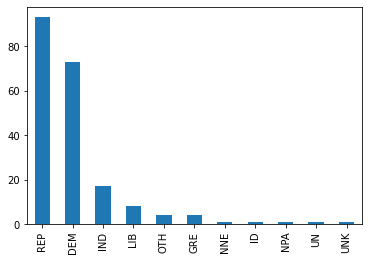

In [104]:
#Murphy had the most time and money in the race so duration doesn't do us much here. Only thing I can see as different is...
#A. He is an incumbent and B. He is a Republican
df_s['Party'].value_counts().plot(kind='bar');
#being an incumbent may mean more than the data is showing but this is clearly a healthy amount of republicans so...
#we will go with it.

In [105]:
#at this point we should be able to model based on money and party to see if it can predict winners in states.
df_h.isna().sum()

ID                   0
Name                 0
Office               0
State Race           0
District             2
Party                1
Seat                 2
Total Con            0
Net Con              0
Net Ops Expense      0
Coverage Start       0
Coverage End         0
Winner               0
Coverage Duration    0
dtype: int64

In [106]:
df_h[df_h['District']==0.0].describe()

,District,Total Con,Net Con,Net Ops Expense,Coverage Duration
count,42.0,4.200000e+01,4.200000e+01,4.200000e+01,42.000000
mean,0.0,5.107952e+05,5.055639e+05,4.351917e+05,425.380952
std,0.0,9.228471e+05,9.163601e+05,8.571496e+05,201.116512
min,0.0,6.000000e+02,6.000000e+02,5.610000e+02,44.000000
25%,0.0,2.256375e+04,2.166100e+04,2.536765e+04,276.000000
50%,0.0,1.640853e+05,1.606078e+05,1.401993e+05,389.500000
75%,0.0,6.485900e+05,6.485900e+05,4.232621e+05,657.000000
max,0.0,4.980915e+06,4.938944e+06,5.055942e+06,679.000000


In [107]:
df_h = df_h.drop(labels=1812, axis = 0)

In [108]:
df_h['District'].fillna(value = 0, inplace = True)

In [109]:
df_h['Party'].fillna('IND', inplace = True)

In [110]:
df_h['Seat'].fillna('CHALLENGER', inplace = True)

In [1286]:
#cleaned up all null values
dfhm = df_h
#used a copy incase I need to make edits later on

In [1287]:
d = defaultdict(LabelEncoder)
le = LabelEncoder() #Didn't actually need encoders as the feature importance returned no categorical data as important.

In [1288]:
dfhm.columns

Index(['ID', 'Name', 'Office', 'State Race', 'District', 'Party', 'Seat',
       'Total Con', 'Net Con', 'Net Ops Expense', 'Coverage Start',
       'Coverage End', 'Winner', 'Coverage Duration'],
      dtype='object')

In [1299]:
x_dfhm = dfhm[['ID', 'Name', 'Office', 'State Race', 'District', 'Party', 'Seat',
       'Total Con', 'Net Con', 'Net Ops Expense', 'Coverage Start',
       'Coverage End', 'Coverage Duration']]
y_dfhm = dfhm['Winner']

#while all features were included after working on the model features with little importance were dropped.

In [1300]:
x_train, x_test, y_train, y_test = train_test_split(x_dfhm, y_dfhm, test_size = 0.2, random_state=0)

In [1442]:
xr_encoded = x_train[['Total Con', 'Net Con','Coverage Duration']]

In [1441]:
xe_encoded = x_test[['Total Con', 'Net Con', 'Coverage Duration']]

In [1504]:
clf = RandomForestClassifier(n_estimators = 1250, 
                             oob_score = True, 
                             n_jobs = -1,
                             random_state = 0,
                             max_features = 3,
                             min_samples_split= 5,
                             min_samples_leaf = 1)
clf.fit(xr_encoded, y_train)

y_pred = clf.predict(xe_encoded)
x_pred = clf.predict(xr_encoded)
#these achieved best results with the test set without over training. used oob_score to ensure cross validation.

In [1505]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#Follow the money and you win

Accuracy: 0.9267399267399268


In [1506]:
print("Accuracy:",metrics.accuracy_score(y_train, x_pred))

Accuracy: 0.9908424908424909


In [1507]:
y = clf.estimators_[0]
y

DecisionTreeClassifier(max_features=3, min_samples_split=5,
                       random_state=209652396)

In [1508]:
clf.estimators_

[DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=209652396),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=398764591),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=924231285),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=1478610112),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=441365315),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=1537364731),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=192771779),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=1491434855),
 DecisionTreeClassifier(max_features=3, min_samples_split=5,
                        random_state=1819583497),
 Decis

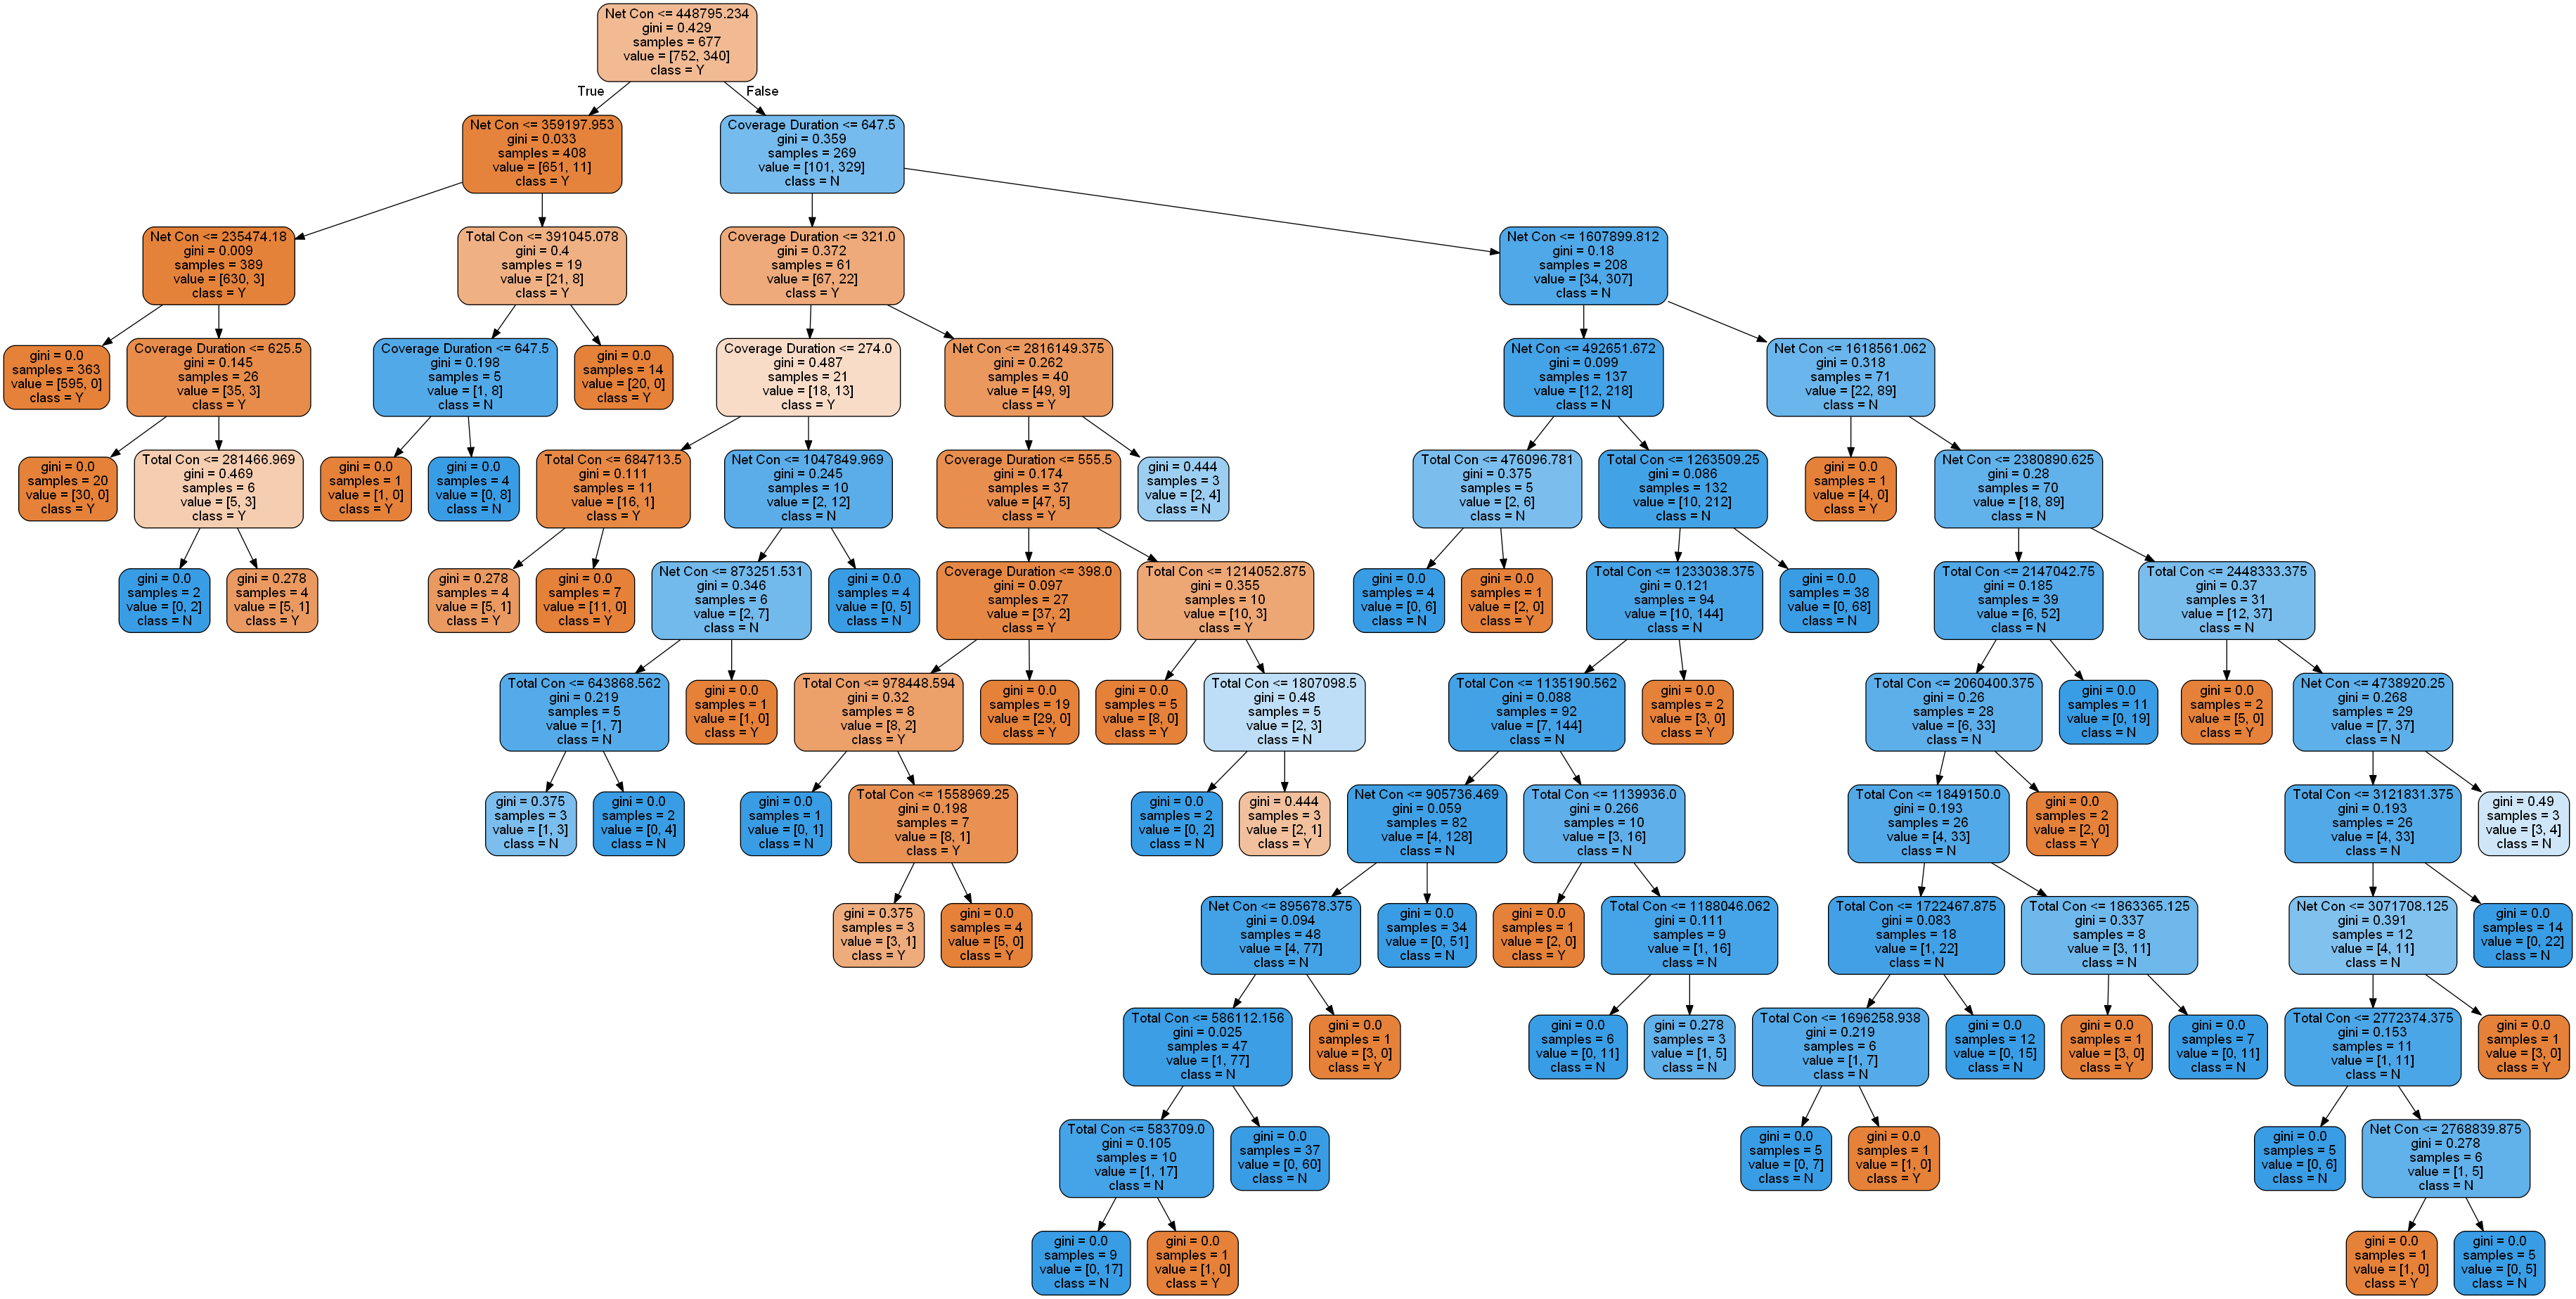

In [1509]:
dot_data = StringIO()
export_graphviz(y, out_file=dot_data, feature_names=xr_encoded.columns, class_names= ['Y','N'], 
                filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [1518]:
feature_list = list(xr_encoded.columns)
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances] 
#not surprising but the biggest difference maker is money followed by how long you campaign for

Variable: Net Con              Importance: 0.71
Variable: Coverage Duration    Importance: 0.22
Variable: Total Con            Importance: 0.07


[None, None, None]

In [1519]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=['Y','N'])
conf_matrix

array([[ 78,  11],
       [  9, 175]], dtype=int64)

In [1520]:
conf_matrix2 = metrics.confusion_matrix(y_train, x_pred, labels=['Y','N'])
conf_matrix2

array([[341,   5],
       [  5, 741]], dtype=int64)

In [1528]:
dfsm = df_s
#running model against the senate results next.

In [1529]:
x_dfsm = dfsm[['ID', 'Name', 'Office', 'State Race', 'District', 'Party', 'Seat',
       'Total Con', 'Net Con', 'Net Ops Expense', 'Coverage Start',
       'Coverage End', 'Coverage Duration']]
y_dfsm = dfsm['Winner']

In [1530]:
a_train, a_test, b_train, b_test = train_test_split(x_dfsm, y_dfsm, test_size = 0.2, random_state=0)

In [1531]:
ar_encoded = a_train[['Total Con', 'Net Con','Coverage Duration']]

In [1532]:
ae_encoded = a_test[['Total Con', 'Net Con', 'Coverage Duration']]

In [1533]:
clf = RandomForestClassifier(n_estimators = 1250, 
                             oob_score = True, 
                             n_jobs = -1,
                             random_state = 0,
                             max_features = 3,
                             min_samples_split= 5,
                             min_samples_leaf = 1)
clf.fit(ar_encoded, b_train)

b_pred = clf.predict(ae_encoded)
a_pred = clf.predict(ar_encoded)

In [1534]:
print("Accuracy:",metrics.accuracy_score(b_test, b_pred))
#everything holds to be true and even more so. 

Accuracy: 0.9512195121951219


In [1535]:
print("Accuracy:",metrics.accuracy_score(b_train, a_pred))

Accuracy: 0.9754601226993865


In [1539]:
dfpm = df_p
#presedential results next

In [1542]:
x_dfpm = dfpm[['ID', 'Name', 'Office', 'State Race', 'District', 'Party', 'Seat',
       'Total Con', 'Net Con', 'Net Ops Expense', 'Coverage Start',
       'Coverage End', 'Coverage Duration']]
y_dfpm = dfpm['Winner']

In [1543]:
m_train, m_test, n_train, n_test = train_test_split(x_dfpm, y_dfpm, test_size = 0.2, random_state=0)

In [1544]:
mr_encoded = m_train[['Total Con', 'Net Con','Coverage Duration']]


In [1549]:
me_encoded = m_test[['Total Con', 'Net Con', 'Coverage Duration']]

(12, 13)

In [1546]:
clf = RandomForestClassifier(n_estimators = 1250, 
                             oob_score = True, 
                             n_jobs = -1,
                             random_state = 0,
                             max_features = 3,
                             min_samples_split= 5,
                             min_samples_leaf = 1)
clf.fit(mr_encoded, n_train)

n_pred = clf.predict(me_encoded)
m_pred = clf.predict(mr_encoded)

In [1547]:
print("Accuracy:",metrics.accuracy_score(n_test, n_pred))
#This was by far the biggest surprise to me given the nature of the dataset but the theory holds up here based on the provided data.

Accuracy: 1.0


In [1548]:
print("Accuracy:",metrics.accuracy_score(n_train, m_pred))

Accuracy: 0.9791666666666666


In [ ]:
#In conclusion I feel strongly with my initial hypothesis. Money matters significantly.